THD (10): 0.00%


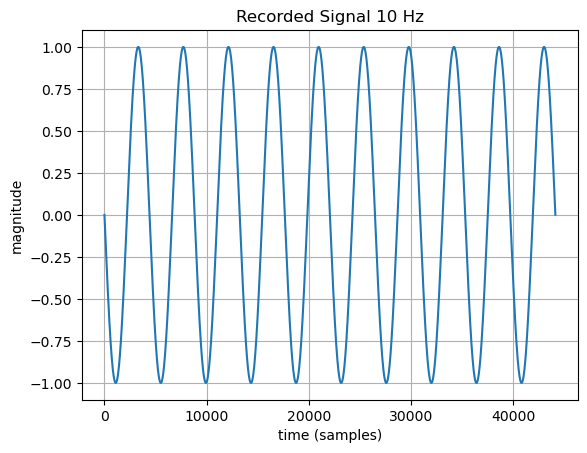

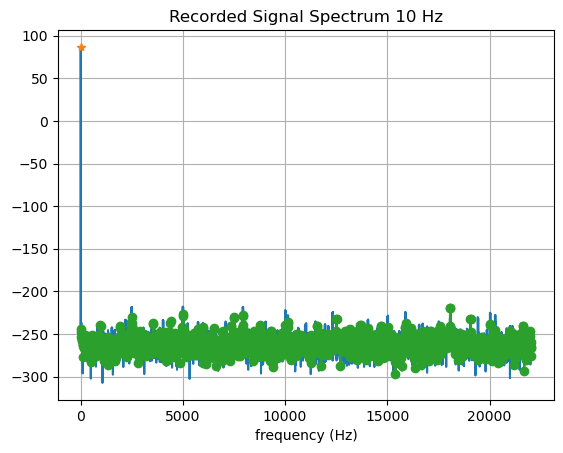

THD (1010): 0.00%


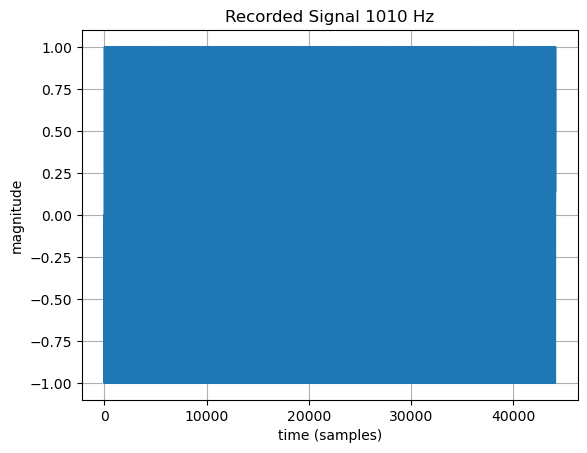

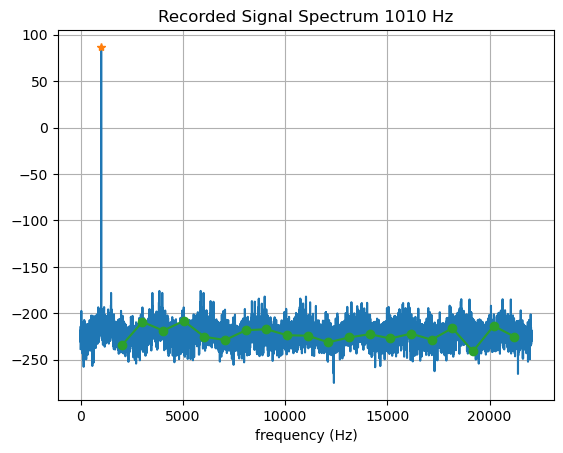

THD (2010): 0.00%


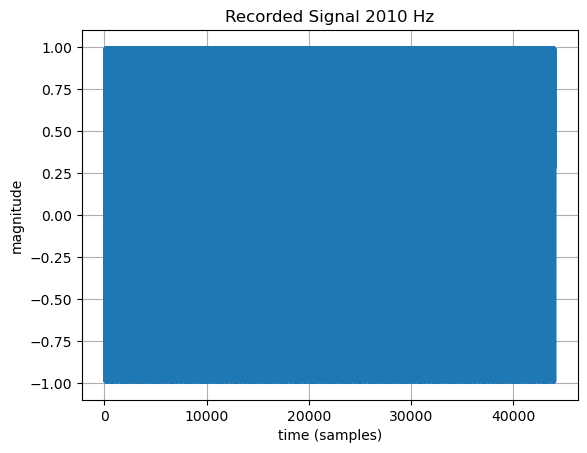

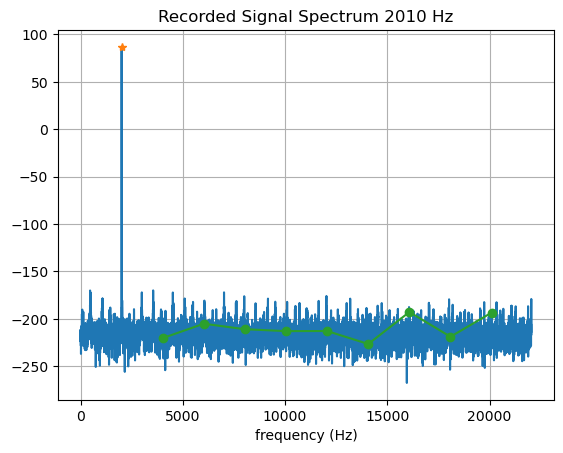

THD (3010): 0.00%


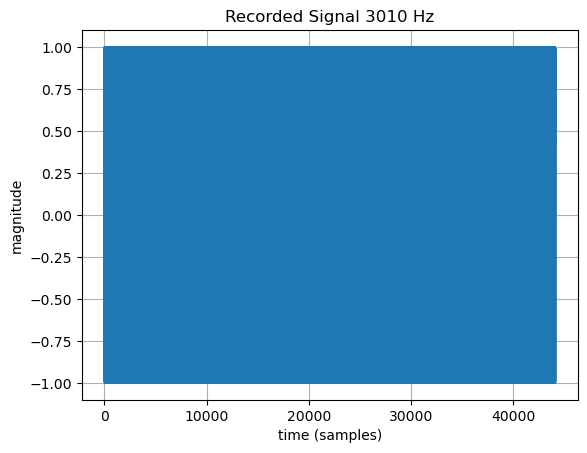

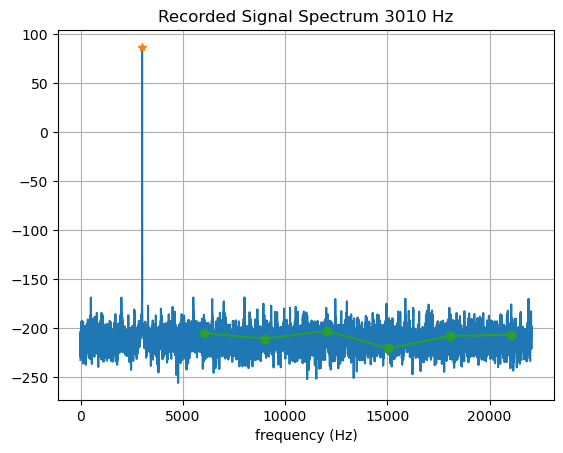

THD (4010): 0.00%


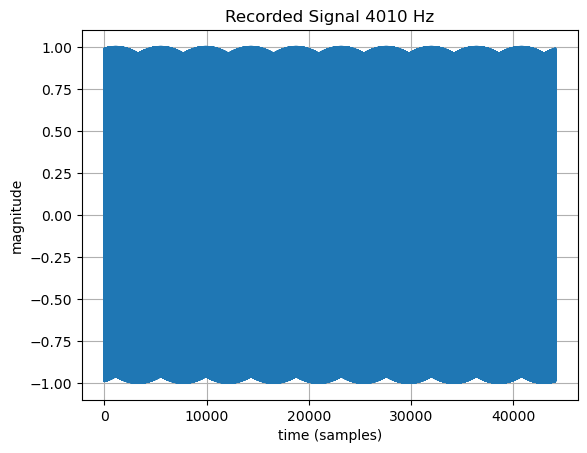

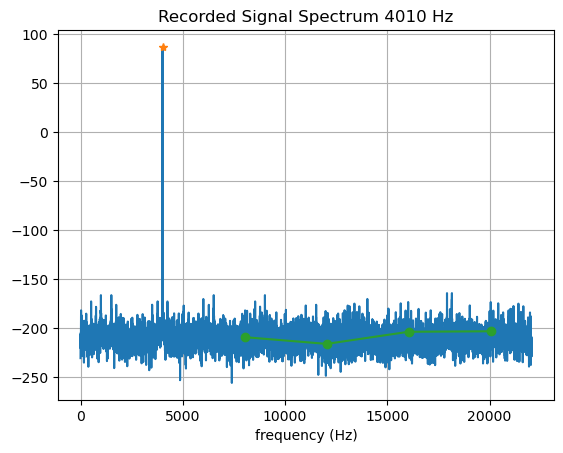

THD (5010): 0.00%


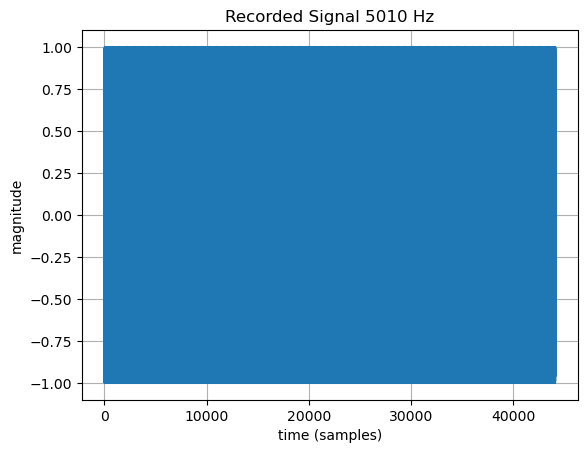

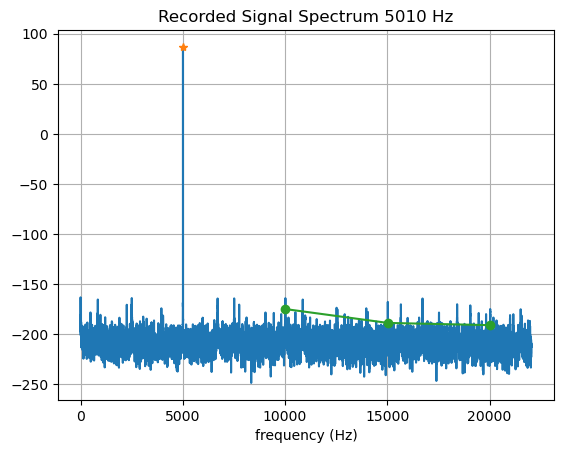

THD (6010): 0.00%


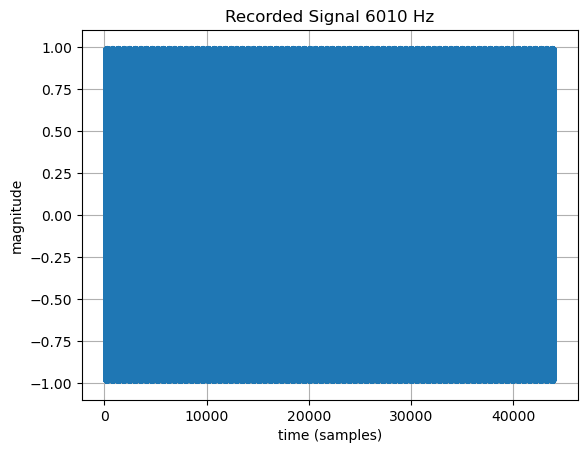

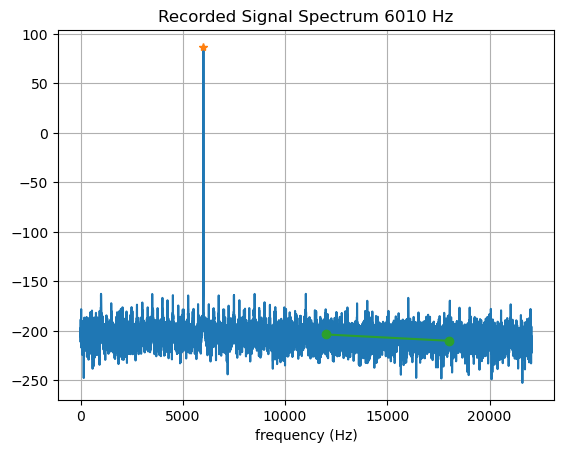

THD (7010): 0.00%


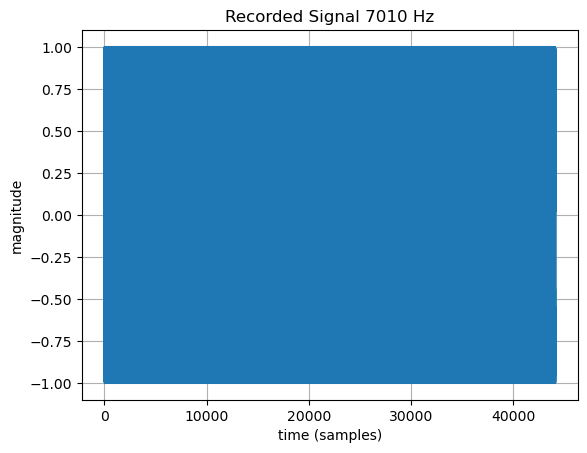

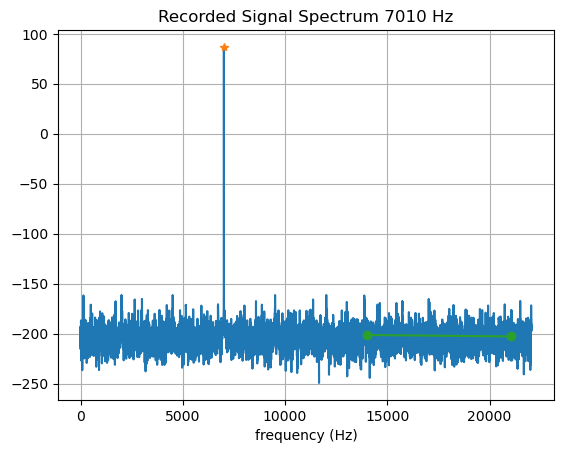

THD (8010): 0.00%


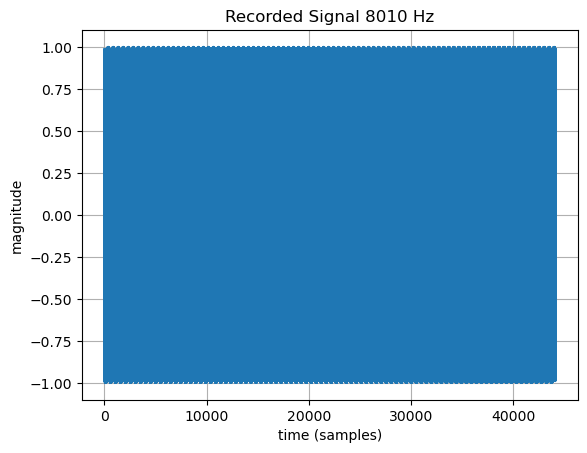

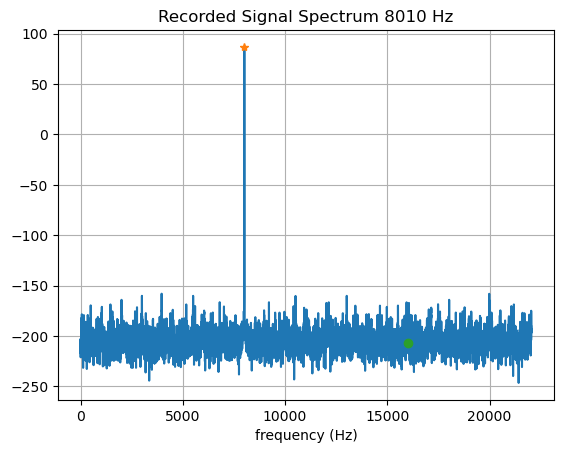

THD (9010): 0.00%


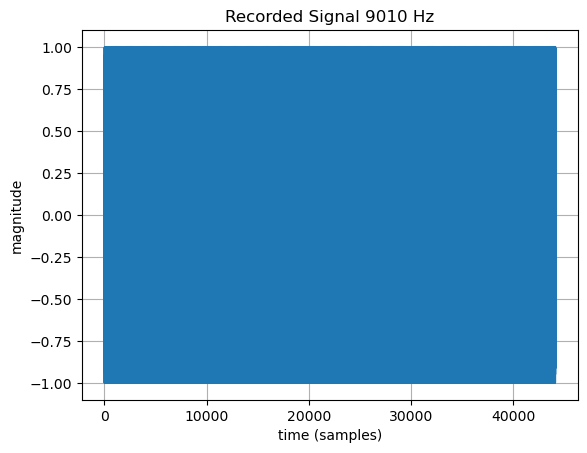

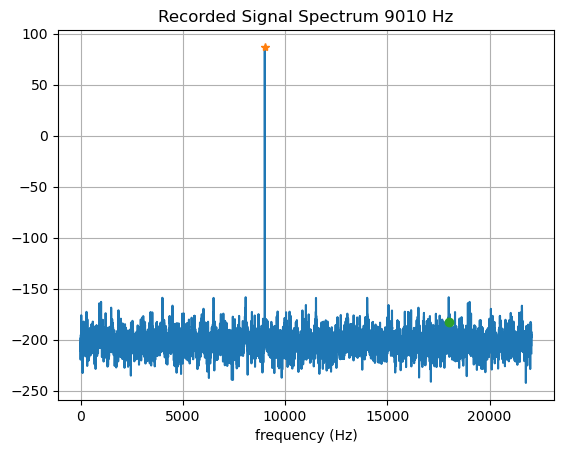

THD (10010): 0.00%


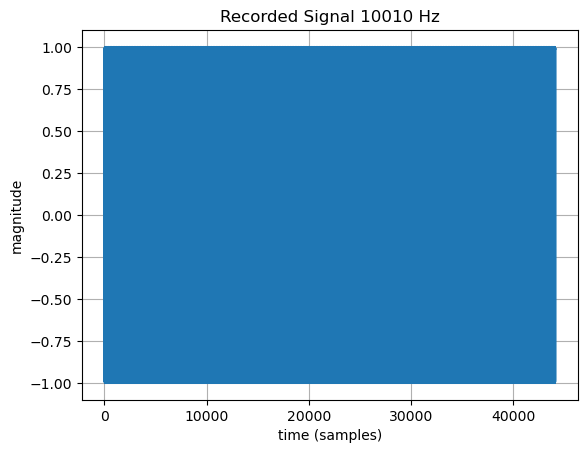

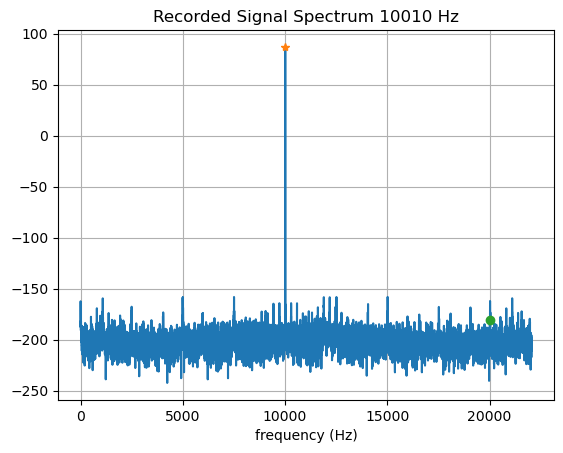

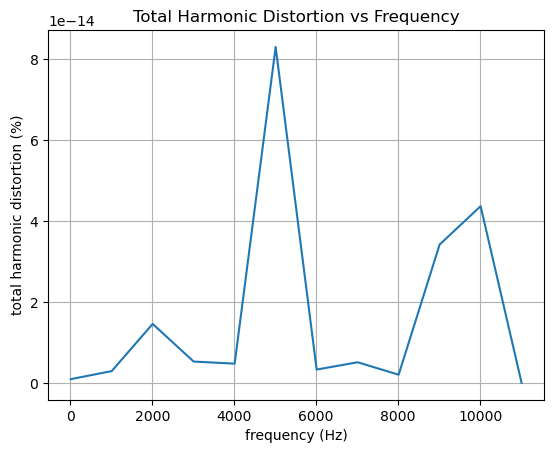

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sys
import pyaudio
import sounddevice as sd
# from thd import thd
from scipy.io import savemat

# Generate tone
fc_approx = 8000 # approximate fc, will choose fc to be a factor of fs, will analyze 1 second of data, so this should be an integer
fs = 44.1e3

freqsToTest =  np.arange(10,fs/4,1000)
thdAll = np.zeros(freqsToTest.shape)
# signalToAnalyze = np.zeros((int(fs),1))  
for freqIdx in range(0,len(freqsToTest)-1):
    fc = freqsToTest[freqIdx]
    # fc = fs/round(fs/fc_approx)
    # bufferSize = 512
    duration = 1.5 # in seconds
    toneAmplitude = 1 # gain factor
    t = np.arange(0,duration,1/fs)
    signalOrig = toneAmplitude * np.sin(2*math.pi*fc*t)

    # # Add synthetic distortion
    # maxHarmonic = math.floor(fs/2/fc)
    # harmonicCoeff = 1e-4*np.random.rand(maxHarmonic-1)

    # signalDistortions = np.zeros(signalOrig.shape)
    # for harmNum in range(2,maxHarmonic):
    #     signalDistortions = signalDistortions + harmonicCoeff[harmNum-2]*np.sin(2*math.pi*fc*t*harmNum)

    # signalToAnalyze = signalOrig + signalDistortions

    # Playback and record signal
    signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)

    # truncate first 0.5 second of signal to allow for recording delay
    startBuffer = 0.25 # in seconds
    endBuffer = 0.25 # in seconds

    signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]
    # savemat('recSig.mat',{'y':signalToAnalyze,'fs':fs})

    # measure spectrum
    spectrum = np.fft.rfft(signalToAnalyze,axis=0)
    fftBin = fs/len(signalToAnalyze)
    # freqX = np.arange(-fs/2,fs/2,fftBin)

    fcIdx = round(fc/fftBin)
    fcOffcenter = fc/fftBin - fcIdx

    if fcOffcenter > 1e-3:
        print("DFT bin not centered on carrier frequency. Unexpected results may occur due to spectral leakage.")

    carrierAmpl = abs(spectrum[fcIdx][0])

    if np.mod(len(spectrum),2)==0: # even number of points in spectrum
        lastPosFreqIdx = int((fs/2)/fftBin) #+ 1
    else: # odd number of points in spectrum
        lastPosFreqIdx = int((fs/2 - fftBin)/fftBin) #+ 1

    harmonicIdx = range(2*fcIdx,lastPosFreqIdx,fcIdx)

    harmonicRMSAmpl = np.sqrt(np.sum(np.square(abs(spectrum[harmonicIdx]))))

    measTHD = harmonicRMSAmpl/carrierAmpl
    print("THD (%d): %.2f%%" % (fc,measTHD*100))
    # print("freqIdx: %d" % (freqIdx))
    thdAll[freqIdx] = measTHD
    
    # Plot time domain signal
    plt.plot(signalToAnalyze)
    plt.title(f'Recorded Signal %d Hz' % fc)
    plt.xlabel('time (samples)')
    plt.ylabel('magnitude')
    plt.grid(visible=True,which='both',axis='both')
    plt.show()
    
    # Plot positive frequency spectrum
    freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
    if np.mod(len(spectrum),2)==0: # even number of points in spectrum
        freqXPos = np.arange(0,int(fs/2),int(fftBin))
    else: # odd number of points in spectrum
        freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
    # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
    # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
    # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),marker="o")
    plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
    plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
    plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
    plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
    plt.xlabel('frequency (Hz)')
    plt.grid(visible=True,which='both',axis='both')
    plt.show()
    time.sleep(.5)

plt.plot(freqsToTest,thdAll)
plt.title('Total Harmonic Distortion vs Frequency')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')



In [2]:
##
# measTHD = thd(signalToAnalyze, fc, fs)
